In [4]:
from typing import Dict, Any, Callable, List, Optional

import re
import subprocess
import tempfile
import pathlib
import concurrent.futures
import os
import functools
import itertools
import collections
import shelve
import json
import numpy as np
import matplotlib.pyplot as plt

import tqdm

In [5]:
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):

            return int(obj)

        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)

        elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
            return {'real': obj.real, 'imag': obj.imag}

        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()

        elif isinstance(obj, (np.bool_)):
            return bool(obj)

        elif isinstance(obj, (np.void)): 
            return None

        return json.JSONEncoder.default(self, obj)

def persistent_memo(f):
    memo = shelve.open("{}.cache".format(f.__name__))
    def wrapped(*args, **kwargs):
        key = json.dumps((args, kwargs), sort_keys=True, cls=NumpyEncoder)
        if key not in memo:
            memo[key] = f(*args, **kwargs)
        return memo[key]
    return wrapped


mungojerrie_path = "mungojerrie/build/mungojerrie"

pattern = re.compile(rf"PAC Probability for tol (\d+(\.\d*)?) is: (?P<satprob>\d+(\.\d*)?)±(?P<std>\d+(\.\d*)?)")

@persistent_memo
def estimate_pac_probability(epsilon: float, 
                             model: str, 
                             min_num_samples: int = 100, 
                             max_est_std: float = 1e-3,
                             reward_type: str = "multi-discount", 
                             discount: float = 0.99999,
                             gammaB: float = 0.99, 
                             learn="Q", 
                             lr_decay: Optional[float] = None,
                             ep_number: int = 100, 
                             ep_length: int = 30,
                             tolerance=0.,
                             model_params: Dict[str, Any] = None):
    if model_params is None:
        model_params = {}

    with tempfile.NamedTemporaryFile(mode='w+') as tmp:
        model_str = pathlib.Path(f"{model}.prism").read_text()
        model_str = model_str.format(**model_params)
        tmp.write(model_str)
        tmp.flush()
        output = subprocess.check_output(
            [
                mungojerrie_path, tmp.name, 
                "--ltl-file", f"{model}.ltl",
                "--est-pac",
                "--reward-type", reward_type, 
                "--discount", str(discount),
                "--gammaB", str(gammaB),
                "--learn", learn, 
                "--tolerance", str(tolerance), 
                "--kkt-lr-decay", str(lr_decay) if lr_decay is not None else "-1",
                "--ep-number", str(ep_number),
                "--ep-length", str(ep_length),
                "--est-pac-probability-min-samples", str(min_num_samples),
                "--est-pac-max-std", str(max_est_std),
                "--est-pac-epsilon", str(epsilon),
                # "--seed", str(2),
            ], 
            stderr=subprocess.DEVNULL
        )
    output = output.decode("utf-8")
    match = pattern.search(output)
    pac_prob = float(match.group("satprob"))
    pac_prob_std = float(match.group("std"))
    return pac_prob, pac_prob_std

In [14]:
def pac_prob_vs_ep_number(est_f, ep_numbers: List[int]):
    return [est_f(ep_number=n) for n in ep_numbers]

p2s = 1 - np.geomspace(0.1, 1e-5, num=5)
ep_numbers = np.geomspace(1, 10**5, num=21, dtype=int)[1:]

probs, errs = collections.defaultdict(list), collections.defaultdict(list)
for p2, ep_number in tqdm.tqdm(list(itertools.product(p2s, ep_numbers))):
    prob, err = estimate_pac_probability(
        epsilon=1e-3, 
        model="models/gltl_paper_fig2",
        model_params=dict(P1=1,P2=p2),
        max_est_std=1e-2, 
#         discount = 0.9999999,
#         gammaB = 0.999, 
        lr_decay = 10,
        ep_number=ep_number, 
        ep_length=10)
    probs[p2].append(prob)
    errs[p2].append(err)

100%|██████████| 100/100 [25:53<00:00, 15.54s/it]


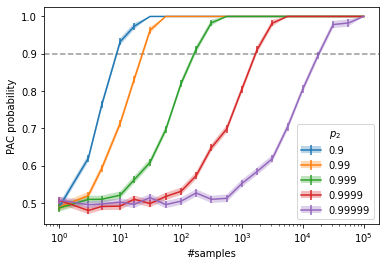

In [43]:
lines = []
for p2 in p2s:
    prob, err = map(np.array, (probs[p2], errs[p2]))
    filler = plt.fill_between(ep_numbers, prob-err, prob+err, alpha=0.3)
    eb = plt.errorbar(ep_numbers, prob, yerr=err)
    lines.append((filler, eb))

plt.gca().set_xscale("log")
plt.gca().set_xlabel("#samples")
plt.gca().set_ylabel("PAC probability")

plt.axhline(0.9, color="#000", alpha=0.4, linestyle="--")

plt.legend(lines, p2s, title="$p_2$")
plt.show()

In [13]:
estimate_pac_probability(
    epsilon=1e-3, 
    model="models/gltl_paper_fig2",
    model_params=dict(P1=1,P2=0.99999),
    max_est_std=1e-1, 
    lr_decay=10,
    ep_length=10,
    ep_number=10**5)

(1.0, 0.0)

In [10]:
np.geomspace(10, 10000, num=8)

array([   10.        ,    26.82695795,    71.9685673 ,   193.06977289,
         517.94746792,  1389.49549437,  3727.59372031, 10000.        ])